In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.optim import Adam
from torchinfo import summary

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
datafolder = './data'
tr_fmnist = datasets.FashionMNIST(root=datafolder, download=True, train=True)
val_fmnist = datasets.FashionMNIST(root=datafolder, download=True, train=False)

tr_x = tr_fmnist.data
tr_y = tr_fmnist.targets

val_x = val_fmnist.data
val_y = val_fmnist.targets

print(tr_x.shape)
print(val_y.shape)

100%|██████████| 26421880/26421880 [00:18<00:00, 1390646.34it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203059.27it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1570639.69it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8065848.71it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000])


In [5]:
class FmnistDataSet(Dataset):
    def __init__(self, x, y) -> None:
        x = x.float()/255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y

    def __getitem__(self, index):
        return self.x[index].to(device), self.y[index].to(device)

    def __len__(self):
        return len(self.x)

train_dataset = FmnistDataSet(tr_x, tr_y)
val_dataset = FmnistDataSet(val_x, val_y)

train_dataloader = DataLoader(train_dataset, 64, True)
val_dataloader   = DataLoader(val_dataset, 64, False)

In [6]:
sample = iter(train_dataloader)
x, y = sample._next_data()
print(x.shape)

torch.Size([64, 1, 28, 28])


In [7]:
model = nn.Sequential(
                    nn.Conv2d(1, 64, 3),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Conv2d(64, 128, 3),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(3200, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10)
).to(device)
optim = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

summary(model, (1,1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 26, 26]           640
├─MaxPool2d: 1-2                         [1, 64, 13, 13]           --
├─ReLU: 1-3                              [1, 64, 13, 13]           --
├─Conv2d: 1-4                            [1, 128, 11, 11]          73,856
├─MaxPool2d: 1-5                         [1, 128, 5, 5]            --
├─ReLU: 1-6                              [1, 128, 5, 5]            --
├─Flatten: 1-7                           [1, 3200]                 --
├─Linear: 1-8                            [1, 256]                  819,456
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.19
Input size (MB): 0.00
Forward/backward pass

In [8]:
def train_batch(x, y, model, opt, loss):
    model.train()

    pred = model(x)

    l1_regularization = 0

    for param in model.parameters():
        l1_regularization += torch.norm(param, 2)

    batch_loss = loss(pred, y) + 0.0001 * l1_regularization

    batch_loss.backward()

    opt.step()

    opt.zero_grad()

    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss):
    model.eval()
    prediction = model(x)
    val_loss = loss(prediction, y)
    return val_loss.item()

In [9]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies     = [], []

for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    for i, (x, y) in enumerate(train_dataloader):
        loss = train_batch(x, y, model, optim, criterion)
        train_epoch_losses.append(loss)
    train_epoch_losses = np.mean(train_epoch_losses)

    for i, (x, y) in enumerate(train_dataloader):
        acc = accuracy(x, y, model)
        train_epoch_accuracies.extend(acc)
    train_epoch_accuracies = np.mean(train_epoch_accuracies)

    val_epoch_loss, val_epoch_accuracy = [], []
    for i, (x, y) in enumerate(val_dataloader):
        val_epoch_accuracy.extend(accuracy(x, y, model))
        val_epoch_loss.append(val_loss(x, y, model, criterion))
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_loss     = np.mean(val_epoch_loss)

    train_losses.append(train_epoch_losses)
    train_accuracies.append(train_epoch_accuracies)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'{epoch}/5: train loss:{train_epoch_losses}, train_acc:{train_epoch_accuracies}')

0/5: train loss:0.4553159845949236, train_acc:0.8764166666666666
1/5: train loss:0.29570551804388, train_acc:0.9044666666666666
2/5: train loss:0.24978993294526264, train_acc:0.9204833333333333
3/5: train loss:0.21731614952545558, train_acc:0.9345666666666667
4/5: train loss:0.1899538169553412, train_acc:0.94845


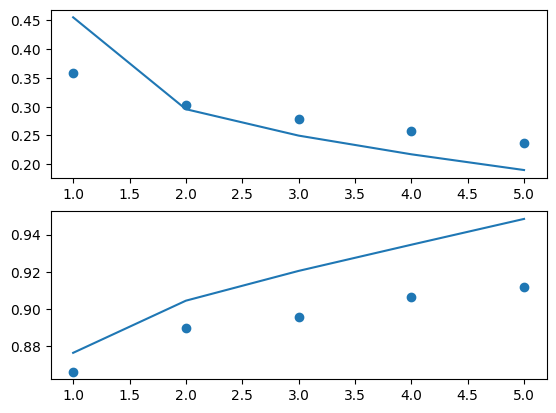

In [10]:
import matplotlib.pyplot as plt
epochs = np.arange(5)+1
fig, ax = plt.subplots(2)

# ax[0].title='training and validation loss'
ax[0].plot(epochs, train_losses)
ax[0].scatter(epochs, val_losses)
ax[1].plot(epochs, train_accuracies)
ax[1].scatter(epochs, val_accuracies)
plt.show()